# Decision Exercise: Mods 17 & 18

## Identify Smoker Applicants Without Lab Work

**Background**

The application process for an individual life insurance policy often requires the applicant to provide a blood and urine sample during a paramedical visit. Although this can be an expensive, time consuming, and a somewhat invasive step, it is required due to the inherent riskiness of insuring an individual compared to offering coverage through a group insurance policy.

A longstanding variable that has shown substantial statistical significance on premature mortality (thus increasing risk) is if the individual regularly smokes. Currently, the blood and urine samples obtained from the paramedical visit is the only reliable way to determine if the individual is a smoker. If this feature could be accurately predicted without the need for a lab screening, life insurance companies could reduce customer acquisition costs by a sizeable amount and provide a less invasive application process for new policyholders.

**Prompt**

1. What factors and methods would you suggest for predicting if someone is a smoker? 
2. How would you validate these results and estimate the business benefits in relation to the accuracy of the model? 
3. What other areas of a life insurance policy application could we use a prediction model to reduce the time and money the business spends on the process?

**Data**

The dataset was obtained from the Machine Learning course from Professor Eric Suess

The dataset is simulated hypothetical medical expenses for patients in the United States, based on data released from the US Census Bureau. The dataset includes 1,338 examples of beneficiaries currently enrolled in the insurance plan, with features indicating characteristics of the patient as well as the total medical expenses charged to the plan for the calendar year.

**Data Description**

* age - age of primary beneficiary (note that people over 65 are not covered by this policy)  
* sex - the biological sex of a policy holder
* bmi - policy holder's weight in kilograms divided by his or her height in meters squared
* sport - number of times a policy holder exercises per week
* children - number of children or dependents covered under a policy
* smoker - policyholder smoking status (being a smoker increases annual charger by $23,848.5 annually)
* region - location of a policyholder
* expenses - medical care expenses incurred by a policyholder

# Import Packages

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sns

from collections import Counter
from numpy import where

from time import time


#Over-sapmling Methods
from imblearn.over_sampling import SMOTE, ADASYN

#Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, r2_score, roc_curve, auc, roc_auc_score

#Train-Test Split
from sklearn.model_selection import train_test_split

#Classifiers
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm, pipeline
from sklearn.kernel_approximation import RBFSampler, Nystroem
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier

#Categorial Features Encoding Methods
from sklearn.preprocessing import OrdinalEncoder

# Help Functions (Generic)

Data

In [13]:
def read_data(data_file):
    return pd.read_csv(data_file)

def df_x_y(df, y_target):
    X = df.drop(y_target, axis=1)
    y = df[y_target]
    return X,y

def missing_val_table(df):
    df_index = ["Missing Count", "Missing %"]
    df_missing_table = pd.DataFrame(index=df_index)

    for col in df.columns:
        missing_val_count = df[col].isnull().sum()
        if missing_val_count > 0:
            df_missing_table[col] = [missing_val_count, missing_val_count/len(df[col])*100]  
    if df_missing_table.empty:
        df_name =[x for x in globals() if globals()[x] is df][0]
        print("%s has no missing value!" %df_name)
    else:
        return df_missing_table
    
def categorial_features(df):
    return [i for i in df.columns if df.dtypes[i]=='object']

Classifier

In [14]:

def decision_tree_model():
    return tree.DecisionTreeClassifier()

def logistic_regression_binary_clf():
    return LogisticRegression(penalty="l2", C=1.0, solver="liblinear")

def balanced_random_forest_clf():
    return BalancedRandomForestClassifier(n_estimators=100, random_state=0)

def linear_svc_clf():
    return LinearSVC(C=1.0, max_iter=1000, tol=1e-3)

def knn_clf():
    return KNeighborsClassifier(n_neighbors = 5)

def bagging_clf():
    return BaggingClassifier()

def random_forest_clf():
    return RandomForestClassifier()

def extra_tree_clf():
    return ExtraTreesClassifier()

    
def classification_app(classification_model, is_roc_plot_needed=True):
    
    X, y = prep_data() # !!! Custom function
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    model = classification_model()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    model_metrics(y_test, y_pred)
    
    #BK: There is some difficulties to draw ROC. Thisis temporarly solution. TODO: find alternative ways!
    if(is_roc_plot_needed is True):
        plot_roc(X_test, y_test, model)

    
def classification_app_inbld(classification_model, imblearn_method, is_test_oversampled, is_roc_plot_needed=True):
    
    X, y = prep_data() # !!! Custom function
    
    if is_test_oversampled == False:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
        X_train, y_train = imblearn_method().fit_sample(X_train, y_train)
    else:
        X_imb, y_imb = imblearn_method().fit_sample(X, y)
        X_train, X_test, y_train, y_test = train_test_split(X_imb, y_imb, test_size=0.2, random_state=0)
 
    model = classification_model()
    model.fit(X_train, y_train)    
    y_pred = model.predict(X_test)
    
    model_metrics(y_test, y_pred)
    
    #BK: There is some difficulties to draw ROC. Thisis temporarly solution. TODO: find alternative ways!
    if(is_roc_plot_needed is True):
        plot_roc(X_test, y_test, model)


Metric

In [15]:
def cross_tab(df, features, y_target):
    for feature in features:
        print(pd.crosstab(df[feature], y_target))
        print('\n')
        
def model_metrics(data_actual, data_pred):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8, 6))
    fig.subplots_adjust(wspace=1)
    df_clf_report = pd.DataFrame(classification_report(data_actual, data_pred, output_dict=True)).T
    print(df_clf_report)
    c_m = confusion_matrix(data_actual, data_pred)
    ax1.set(title = "Confisuon Matrix", ylabel = "Actual Data", xlabel = "Predicted Data")
    sns.heatmap(c_m, annot=True, fmt=".0f", ax=ax1, square=True, cbar_kws={'orientation': 'horizontal'}) #, vmin=0, vmax=max(map(lambda x: x[2], c_m))
    sns.heatmap(df_clf_report.iloc[: , :-1], annot=True, ax=ax2, square=True, cbar_kws={'orientation': 'horizontal'}) # , vmin=0, vmax=1
    plt.yticks(rotation=0)

Plot

In [16]:
def plot_roc(data1, data2, model):
    plt.figure(figsize=(6,6))
    plt.xlabel('FPR', fontsize = 20)
    plt.ylabel('TPR', fontsize = 20)
    plt.title('ROC Curve')
    plt.plot([0,1],[0,1], 'r--', label='Random Guess')
    y_pred_proba = model.predict_proba(data1)[:,1]  
    fpr, tpr, _ = roc_curve(data2,  y_pred_proba)
    auc = roc_auc_score(data2, y_pred_proba)
    plt.plot(fpr,tpr,label="auc="+str(auc))
    plt.legend(loc=4)
    
#plot_roc2 has been taken from Rob´s Office Hour Week16
def plot_roc2(data1, data2, model):
    fpr, tpr, _ = roc_curve(data2, model.predict_proba(data1)[:,1])
    model_auc = auc(fpr,tpr)

    plt.figure(figsize=(6,6))
    plt.plot([0,1],[0,1])
    plt.xlabel('FPR', fontsize = 20)
    plt.xticks(fontsize = 20)
    plt.ylabel('TPR', fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.title('ROC Curve\nAUC : ' + str(model_auc.round(3)), fontsize = 18)
    plt.plot(fpr, tpr)

# Help Functions (Custom)

In [17]:
def data_process(df):    
    smoker_map = {'yes': 1, 'no': 0}
    df['smoker'] = df['smoker'].map(smoker_map)
    
    dummy_cols = ['sex', 'region']
    df = pd.get_dummies(df, columns=dummy_cols, prefix=dummy_cols)
    
    return df
    
def prep_data():
    df = data_process(read_data(DATAFILE))
    return df_x_y(df, "smoker")

# Data Set Overview

Define our data file to a variable

In [18]:
DATAFILE = './datasets/insurance-med-expenses.csv'

Read the data file into a DataFrame

In [19]:
df = pd.read_csv(DATAFILE)

View the head of our DataFrame

In [20]:
df.head()

,age,sex,bmi,sport,children,smoker,region,expenses
0,19,female,27.9,3,0,yes,southwest,16884.92
1,18,male,33.8,3,1,no,southeast,1725.55
2,28,male,33.0,2,3,no,southeast,4449.46
3,33,male,22.7,2,0,no,northwest,21984.47
4,32,male,28.9,2,0,no,northwest,3866.86


Check missing value.

In [21]:
missing_val_table(df)

df has no missing value!


Overview y value

In [23]:
X,y = df_x_y(df, "smoker")

no     1064
yes     274
Name: smoker, dtype: int64
no     79.521674
yes    20.478326
Name: smoker, dtype: float64


<AxesSubplot:>

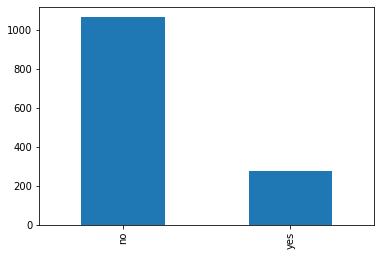

In [25]:
print(y.value_counts())
print(y.value_counts(normalize=True)*100)

y.value_counts().plot(kind="bar")

Define categorial features.

In [26]:
print(X.columns)

Index(['age', 'sex', 'bmi', 'sport', 'children', 'region', 'expenses'], dtype='object')


In [27]:
cat_features=categorial_features(X)
print(cat_features)

['sex', 'region']


In [28]:
#cross_tab(X, cat_features , y)

Relationship between features

In [29]:
#resource for this cell : https://www.kaggle.com/venky12347/insurance-premium
df.groupby("smoker").expenses.agg(["mean","median","count"])

,mean,median,count
smoker,,,
no,8434.268449,7345.405,1064
yes,32050.231971,34456.350,274


<AxesSubplot:xlabel='smoker', ylabel='expenses'>

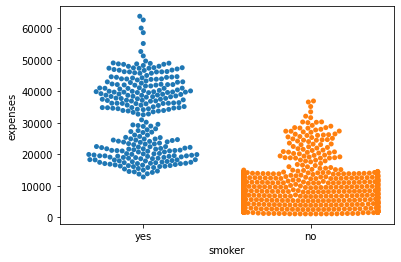

In [30]:
#resource for this cell : https://www.kaggle.com/venky12347/insurance-premium
sns.swarmplot(x=df['smoker'],
              y=df['expenses'])

smoker        no       yes     Total
sport                               
0       0.183857  0.038864  0.222720
1       0.246637  0.064275  0.310912
2       0.233931  0.066517  0.300448
3       0.130792  0.035127  0.165919
Total   0.795217  0.204783  1.000000


<AxesSubplot:xlabel='sport'>

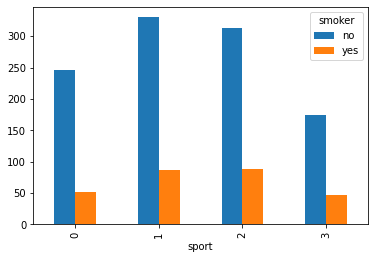

In [31]:
print(pd.crosstab(df["sport"], df["smoker"], margins=True, margins_name="Total",normalize=True))
pd.crosstab(df['sport'], df["smoker"]).plot(kind="bar")

In [32]:
pd.crosstab(df["sex"], df["smoker"], margins=True, margins_name="Total",normalize=True)

smoker,no,yes,Total
sex,,,
female,0.408819,0.085949,0.494768
male,0.386398,0.118834,0.505232
Total,0.795217,0.204783,1.000000


In [33]:
pd.crosstab(df["region"], df["smoker"], margins=True, margins_name="Total",normalize=True)

smoker,no,yes,Total
region,,,
northeast,0.192078,0.050075,0.242152
northwest,0.199552,0.043348,0.242900
southeast,0.204036,0.068012,0.272048
southwest,0.199552,0.043348,0.242900
Total,0.795217,0.204783,1.000000


smoker,no,yes,Total
bmi,,,
"(15, 17]",0.002641,0.000000,0.002641
"(17, 19]",0.014965,0.004401,0.019366
"(19, 21]",0.026408,0.008803,0.035211
"(21, 23]",0.048415,0.014965,0.063380
"(23, 25]",0.076585,0.020246,0.096831
"(25, 27]",0.098592,0.022887,0.121479
"(27, 29]",0.122359,0.032570,0.154930
"(29, 31]",0.119718,0.026408,0.146127
"(31, 33]",0.111796,0.024648,0.136444


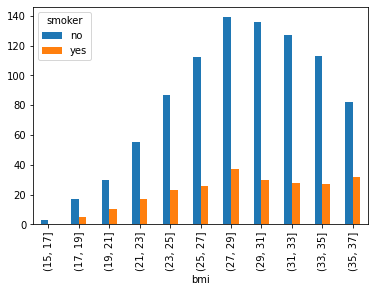

In [34]:
bins = [15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37]
bmi_interval = pd.cut(df['bmi'], bins=bins)

pd.crosstab(bmi_interval, df["smoker"]).plot(kind="bar")
pd.crosstab(bmi_interval, df["smoker"], normalize=True, margins=True, margins_name="Total")

smoker,no,yes,Total
age,,,
"(15, 20]",0.094918,0.029148,0.124066
"(20, 25]",0.085202,0.019432,0.104634
"(25, 30]",0.080717,0.022422,0.103139
"(30, 35]",0.077728,0.019432,0.097160
"(35, 40]",0.073991,0.020927,0.094918
"(40, 45]",0.077728,0.024664,0.102392
"(45, 50]",0.086697,0.020927,0.107623
"(50, 55]",0.086697,0.017937,0.104634
"(55, 60]",0.079970,0.013453,0.093423


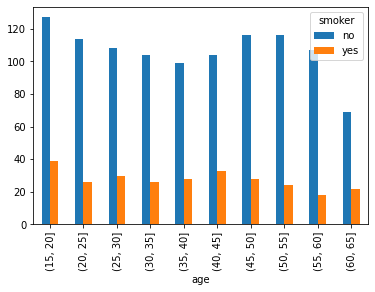

In [35]:
bins = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70]
age_interval = pd.cut(df['age'], bins=bins)

pd.crosstab(age_interval, df["smoker"]).plot(kind="bar")
pd.crosstab(age_interval, df["smoker"], normalize=True, margins=True, margins_name="Total")

In [36]:
#print(df['expenses'].value_counts(bins=10, normalize=True))
#df['expenses'].value_counts(bins=10).plot(kind="bar")

In [37]:
#print(df['age'].value_counts(bins=5, normalize=True))
#df['age'].value_counts(bins=5).plot(kind="bar")

# Data Preprocess

Encoding categorial features

THE ENCODING FOR CATEGORIAL FEATURES HAS BEEN DONE IN THE CUSTOM FUNCTION "data_process()".

# Decision Tree Classifier

              precision    recall  f1-score     support
0              0.985714  0.971831  0.978723  213.000000
1              0.896552  0.945455  0.920354   55.000000
accuracy       0.966418  0.966418  0.966418    0.966418
macro avg      0.941133  0.958643  0.949539  268.000000
weighted avg   0.967416  0.966418  0.966745  268.000000


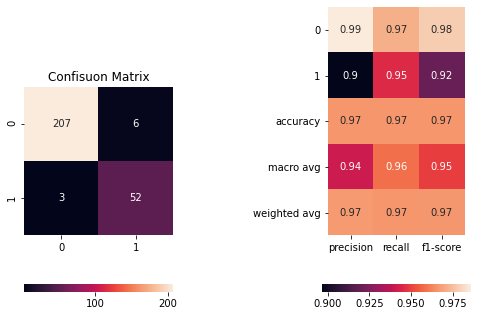

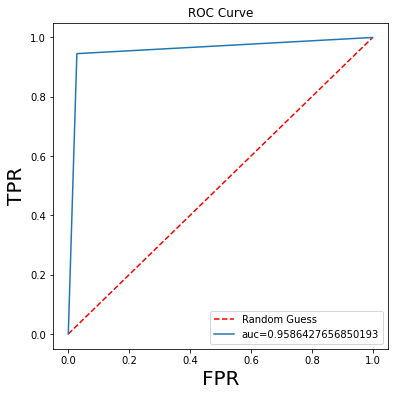

In [38]:
classification_app(decision_tree_model)

# Logistic Regression Binary Classifier

              precision    recall  f1-score     support
0              0.976303  0.967136  0.971698  213.000000
1              0.877193  0.909091  0.892857   55.000000
accuracy       0.955224  0.955224  0.955224    0.955224
macro avg      0.926748  0.938114  0.932278  268.000000
weighted avg   0.955964  0.955224  0.955518  268.000000


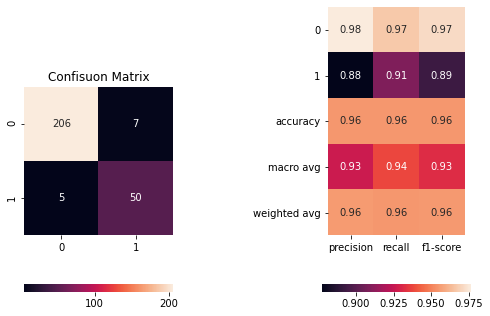

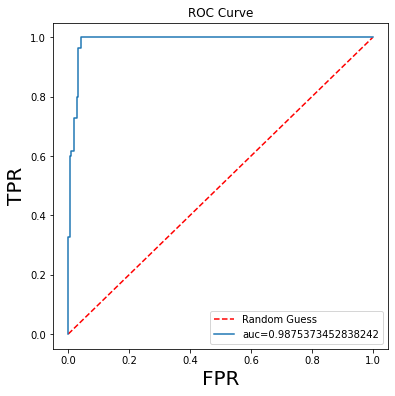

In [39]:
classification_app(logistic_regression_binary_clf)

# Linear SVC Classifier

c:\users\bilgen\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


              precision    recall  f1-score     support
0              0.908696  0.981221  0.943567  213.000000
1              0.894737  0.618182  0.731183   55.000000
accuracy       0.906716  0.906716  0.906716    0.906716
macro avg      0.901716  0.799701  0.837375  268.000000
weighted avg   0.905831  0.906716  0.899980  268.000000


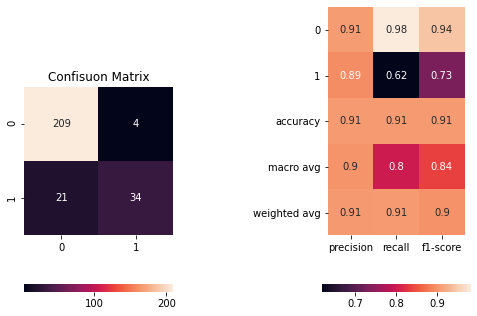

In [40]:
classification_app(linear_svc_clf, False)

# K-Nearest-Neighbor Classifier

              precision    recall  f1-score     support
0              0.949074  0.962441  0.955711  213.000000
1              0.846154  0.800000  0.822430   55.000000
accuracy       0.929104  0.929104  0.929104    0.929104
macro avg      0.897614  0.881221  0.889070  268.000000
weighted avg   0.927952  0.929104  0.928359  268.000000


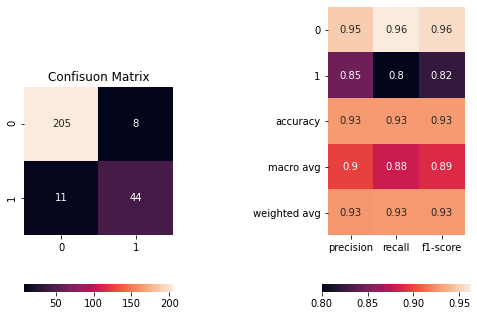

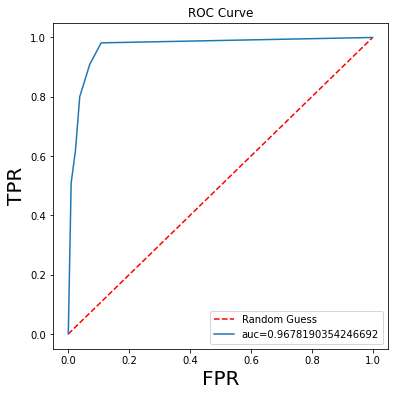

In [41]:
classification_app(knn_clf)

# Bagging Classifier

              precision    recall  f1-score     support
0              0.976415  0.971831  0.974118  213.000000
1              0.892857  0.909091  0.900901   55.000000
accuracy       0.958955  0.958955  0.958955    0.958955
macro avg      0.934636  0.940461  0.937509  268.000000
weighted avg   0.959267  0.958955  0.959092  268.000000


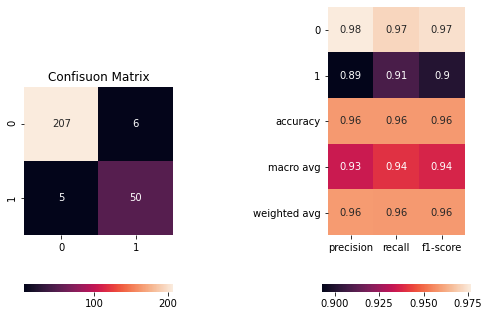

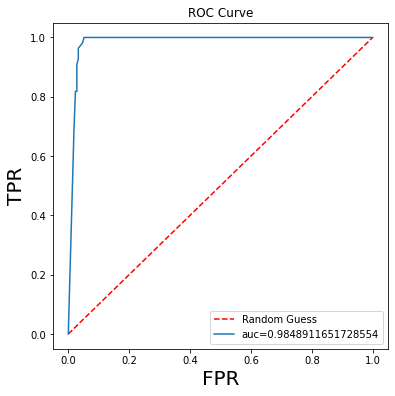

In [42]:
classification_app(bagging_clf)

# Random Forest Classifier

              precision    recall  f1-score     support
0              0.980861  0.962441  0.971564  213.000000
1              0.864407  0.927273  0.894737   55.000000
accuracy       0.955224  0.955224  0.955224    0.955224
macro avg      0.922634  0.944857  0.933150  268.000000
weighted avg   0.956962  0.955224  0.955797  268.000000


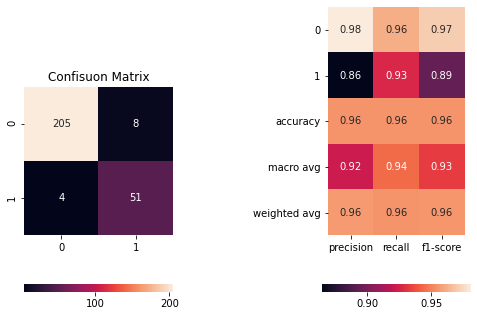

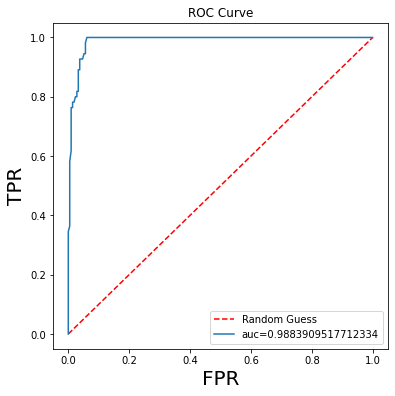

In [43]:
classification_app(random_forest_clf)

# Extra Tree Classifier

              precision    recall  f1-score     support
0              0.967136  0.967136  0.967136  213.000000
1              0.872727  0.872727  0.872727   55.000000
accuracy       0.947761  0.947761  0.947761    0.947761
macro avg      0.919932  0.919932  0.919932  268.000000
weighted avg   0.947761  0.947761  0.947761  268.000000


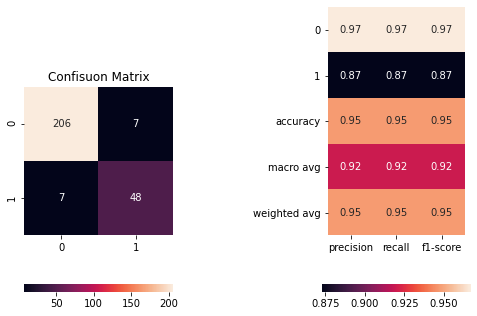

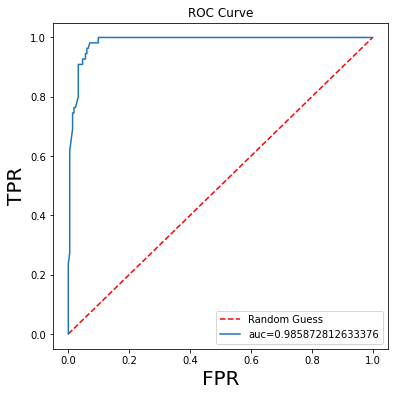

In [44]:
classification_app(extra_tree_clf)

# Balanced Random Forest Classifier

              precision    recall  f1-score     support
0              1.000000  0.924883  0.960976  213.000000
1              0.774648  1.000000  0.873016   55.000000
accuracy       0.940299  0.940299  0.940299    0.940299
macro avg      0.887324  0.962441  0.916996  268.000000
weighted avg   0.953752  0.940299  0.942924  268.000000


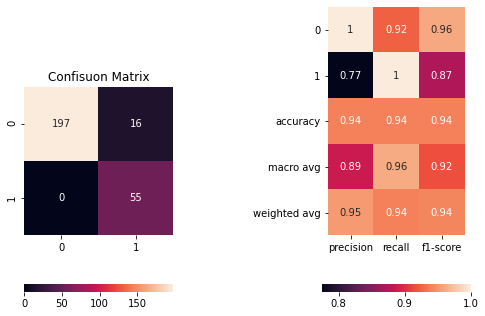

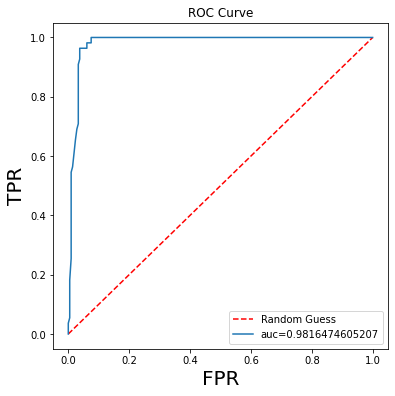

In [45]:
classification_app(balanced_random_forest_clf)